Loaded 519 images from /content/drive/MyDrive/collab/casting_512x512/ok_front
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      4864      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256, 256, 64)      0         
                                                                 
 dropout (Dropout)           (None, 256, 256, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     204928    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128, 128, 128)     0         
                                                                 
 dropout_1 (Dropout)         (None, 128, 128, 128)     0         
                                          

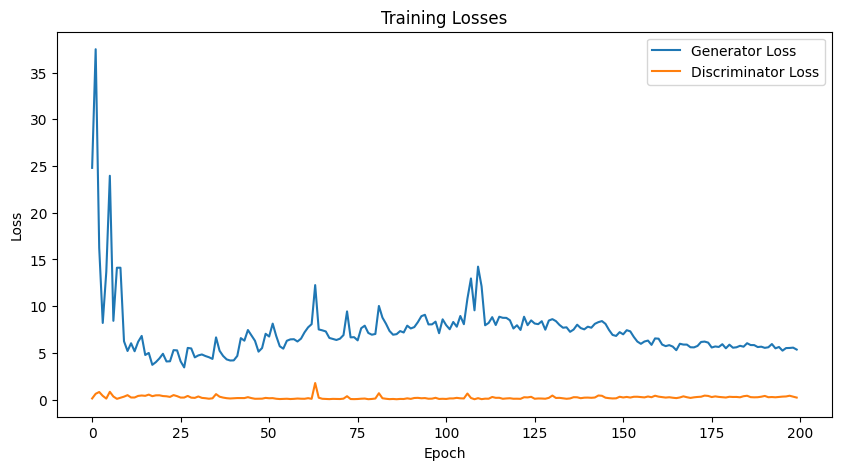

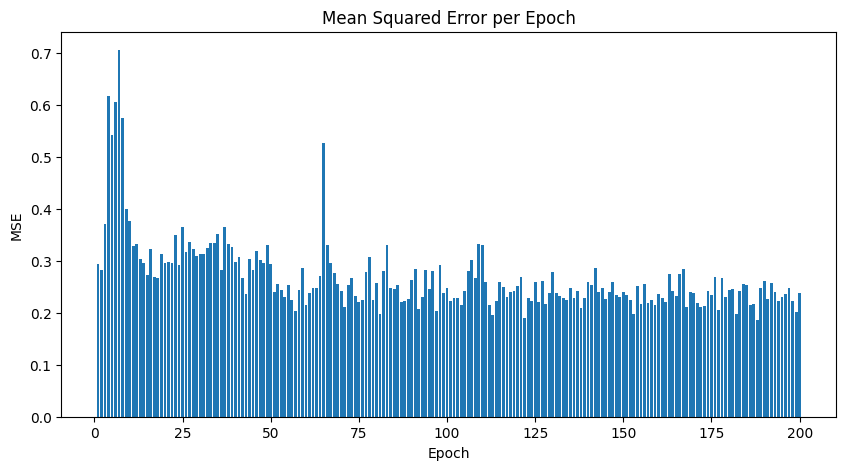

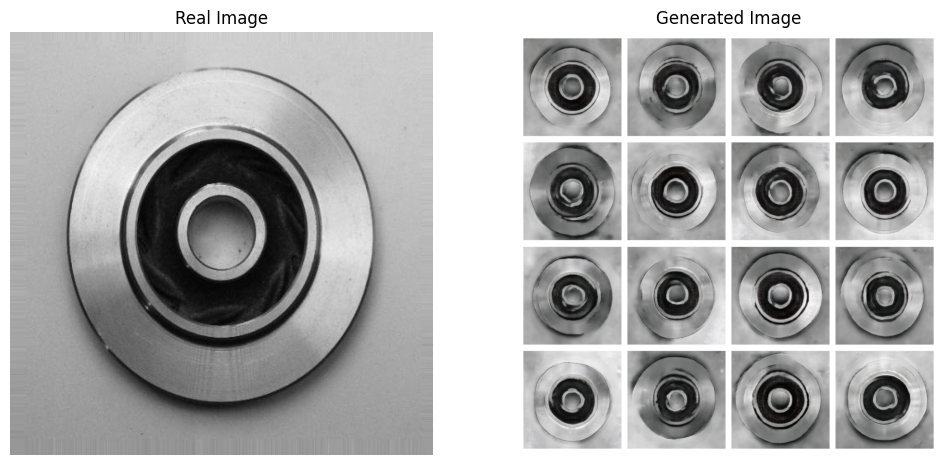

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from PIL import Image
import glob
from sklearn.metrics import mean_squared_error
from scipy import ndimage
import os
import datetime

# Paths
non_defective_dir = '/content/drive/MyDrive/collab/casting_512x512/ok_front'
output_dir = '/content/drive/MyDrive/collab/16_12_Results'

# Load Images from Directory
def load_images(directory, size=(512, 512)):  # Resize to 512x512
    images = []
    for filename in glob.glob(directory + '/*.jpeg'):
        img = Image.open(filename).resize(size)
        images.append(np.array(img))
    print(f"Loaded {len(images)} images from {directory}")
    return np.array(images)

def preprocess_images(images):
    images = images.astype('float32')
    images = (images - 127.5) / 127.5  # Normalize to [-1, 1]
    return images

# Load and preprocess dataset
dataset = load_images(non_defective_dir)
dataset = preprocess_images(dataset)

# Define the Generator Model
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(32*32*512, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((32, 32, 512)),  # Start with a 32x32 image

        # Upscale to 64x64
        layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Upscale to 128x128
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Upscale to 256x256
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Final upscale to 512x512
        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')  # 3 channels for color image
    ])
    return model


# Define the Discriminator Model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[512, 512, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model



# Create the Generator and Discriminator
generator = make_generator_model()
discriminator = make_discriminator_model()
discriminator.summary()
generator.summary()


# TensorBoard setup
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/' + current_time
summary_writer = tf.summary.create_file_writer(log_dir)

# Function to save generated images
def save_generated_images(epoch, generator, noise_dim, examples=16, dim=(4, 4), figsize=(10,10)):
    noise = tf.random.normal([examples, noise_dim])
    generated_images = generator(noise, training=False)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        # Rescale the images from [-1, 1] to [0, 1] and display without grayscale colormap
        plt.imshow((generated_images[i] + 1) / 2)
        plt.axis('off')
    plt.tight_layout()

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plt.savefig(f'{output_dir}/generated_image_epoch_{epoch}.png')
    plt.close()


# Define the loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Adjusting the Learning Rate and Optimizer
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Model Checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


# Training Step Function
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

 # Log losses to TensorBoard
    with summary_writer.as_default():
        tf.summary.scalar('generator_loss', gen_loss, step=generator_optimizer.iterations)
        tf.summary.scalar('discriminator_loss', disc_loss, step=discriminator_optimizer.iterations)

        return gen_loss, disc_loss


# Training loop to record losses
def train(dataset, epochs, batch_size, noise_dim):
    buffer_size = len(dataset)
    batch_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(buffer_size).batch(batch_size)

    # Lists for storing losses
    generator_losses = []
    discriminator_losses = []
    mse_values = []  # Initialize the mse_values list

    for epoch in range(epochs):
        gen_loss_total = 0
        disc_loss_total = 0
        num_batches = 0

        # Generate images for metrics
        test_noise = tf.random.normal([batch_size, noise_dim])
        test_generated_images = generator(test_noise, training=False)


        # Calculate and print the Mean Squared Error
        mse = mean_squared_error(dataset[:batch_size].flatten(), test_generated_images.numpy().flatten())
        mse_values.append(mse)  # Store each MSE value
        print(f"Mean Squared Error: {mse}")

        for image_batch in batch_dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_total += gen_loss
            disc_loss_total += disc_loss
            num_batches += 1

        # Calculate average loss and add to lists
        avg_gen_loss = gen_loss_total / num_batches
        avg_disc_loss = disc_loss_total / num_batches
        generator_losses.append(avg_gen_loss)
        discriminator_losses.append(avg_disc_loss)

        # Reporting the average loss per batch
        print(f'Epoch {epoch+1}, Generator Loss: {avg_gen_loss}, Discriminator Loss: {avg_disc_loss}')

        # Save the model and images periodically
        if (epoch + 1) % 10 == 0:
            save_generated_images(epoch, generator, noise_dim)
            checkpoint.save(file_prefix=checkpoint_prefix)

    # Plotting the losses
    plt.figure(figsize=(10, 5))
    plt.plot(generator_losses, label='Generator Loss')
    plt.plot(discriminator_losses, label='Discriminator Loss')
    plt.title("Training Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.bar(range(1, epochs+1), mse_values)
    plt.title("Mean Squared Error per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.show()


# Set your training parameters
EPOCHS = 200
noise_dim = 100
BATCH_SIZE = 8

# Train the GAN
train(dataset, EPOCHS, BATCH_SIZE, noise_dim)

# Path to the real image and the last generated image
real_image_path = os.path.join(non_defective_dir, 'cast_ok_0_129.jpeg')  # Replace with your real image filename
generated_image_path = os.path.join(output_dir, f'generated_image_epoch_199.png')  # EPOCHS should be the same as in your GAN training

# Load the images
real_image = Image.open(real_image_path)
generated_image = Image.open(generated_image_path)

# Display the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(real_image)
plt.title('Real Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(generated_image)
plt.title('Generated Image')
plt.axis('off')

plt.show()